# extract frames & image transform

Actual frame rate:  59.93711117121991
Calculate fps: 60
pick point clockwise
[(134, 369), (1704, 354), (1712, 881), (129, 894)]
domain pixel w-h [1583, 540]
domain pixel ratio 2.9314814814814816
frame count =  60  ,current time =  1.0


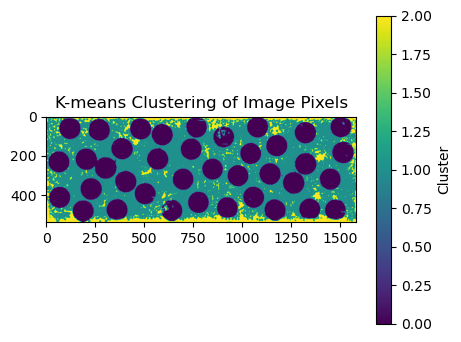

{0: 347613, 1: 404095, 2: 103112}


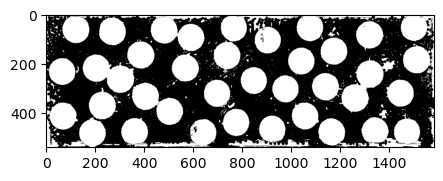

{0: 445493, 255: 409327}
frame count =  120  ,current time =  2.0
{0: 347624, 1: 403467, 2: 103729}
{0: 445973, 255: 408847}
frame count =  180  ,current time =  3.0
{0: 347792, 1: 404216, 2: 102812}
{0: 446119, 255: 408701}
frame count =  240  ,current time =  4.0
{0: 348395, 1: 405059, 2: 101366}
{0: 447487, 255: 407333}
frame count =  300  ,current time =  5.0
{0: 348261, 1: 403675, 2: 102884}
{0: 446079, 255: 408741}
frame count =  360  ,current time =  6.0
{0: 347293, 1: 403144, 2: 104383}
{0: 444695, 255: 410125}
frame count =  420  ,current time =  7.0
{0: 348109, 1: 405200, 2: 101511}
{0: 446777, 255: 408043}
frame count =  480  ,current time =  8.0
{0: 348023, 1: 404957, 2: 101840}
{0: 445543, 255: 409277}
frame count =  540  ,current time =  9.0
{0: 348195, 1: 404870, 2: 101755}
{0: 445752, 255: 409068}
frame count =  600  ,current time =  10.0
{0: 348242, 1: 404846, 2: 101732}
{0: 445383, 255: 409437}
frame count =  660  ,current time =  11.0
{0: 348127, 1: 404664, 2: 102029

In [ ]:
import cv2
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def mouse_callback(event, x, y, flags, params):
    if event == cv2.EVENT_LBUTTONDOWN:
        if len(params['points']) < 4:
            params['points'].append((x, y))
            cv2.circle(params['img'], (x, y), 5, (0, 255, 0), -1)
            cv2.imshow("Image-pick point clockwise", params['img'])

def transform_image(input_image, points):
    width, height = [ max([points[0][0],points[1][0],points[2][0],points[3][0]])-min([points[0][0],points[1][0],points[2][0],points[3][0]]) , max([points[0][1],points[1][1],points[2][1],points[3][1]])-min([points[0][1],points[1][1],points[2][1],points[3][1]])]
    pts1 = np.float32(points)
    pts2 = np.float32([[0, 0], [width, 0], [width, height], [0, height]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result0 = cv2.warpPerspective(input_image, matrix, (width, height))
    return [result0,[width, height]]
    
def extract_frames_collecting_data(video_path, output_folder, initkmeans, start_time_of_suffution, fine_frames_per_sec, finepixelvalue, interval=1):
    pickpointstatus = False
    initfitmodel = False
    kmeans=initkmeans
    finepixelList = []
    finepixelList2 = []
    
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video file")
        return

    frame_count = 0
    fps = cap.get(cv2.CAP_PROP_FPS)
    print ("Actual frame rate: ",fps)
    fps = math.ceil(fps)
    print ("Calculate fps:", fps)
    while True:
        ret, frame = cap.read()
        
        ### rotatio ####################################################
        frame= cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
        
        if not ret:
            break

        frame_count += 1
        #print ("current frame", frame_count)

        # Calculate time in seconds
        current_time = frame_count / fps
        #print (current_time)
        # Check if the current time is a multiple of the interval
        if frame_count % fps == 0 or ( current_time>start_time_of_suffution  and  frame_count % (fps/fine_frames_per_sec) == 0):
            # Save the frame
            output_path = os.path.join(output_folder, f"frame_{frame_count}_transformted.jpg")
            
            input_image = frame
            if pickpointstatus == False:
                # Create a copy of the input image for drawing points
                img_copy = input_image.copy()
                
                # Store the points
                points = []   
                # Set mouse callback function
                cv2.namedWindow("Image-pick point clockwise")
                cv2.setMouseCallback("Image-pick point clockwise", mouse_callback, {'img': img_copy, 'points': points})
                
                # Display the input image
                cv2.imshow("Image-pick point clockwise", img_copy)
                cv2.waitKey(0)
                print("pick point clockwise")
                print(points)
            result = transform_image(input_image, points)
            if pickpointstatus == False:
                cv2.imshow("Transformed Image", result[0])
                cv2.waitKey(0)
                cv2.destroyAllWindows()
                print("domain pixel w-h",result[1])
                print("domain pixel ratio",result[1][0]/result[1][1])
                # save frist pic
                # cv2.imwrite(output_path, result[0])
                pickpointstatus = True
            # cv2.imwrite(output_path, result[0])
            print("frame count = ",frame_count," ,current time = ",current_time)
            finepixel , kmeans=collectingResultKmeans(result[0], kmeans, initfitmodel,current_time)
            finepixel2=collectingResultcombined_mask(result[0],current_time)
            initfitmodel = True
            finepixelList.append([current_time, finepixel[finepixelvalue], finepixel2])

    finepixelList=np.array(finepixelList)
    suminitialfinepixel = sum(finepixelList[:start_time_of_suffution , 1: ])
    averageinitialfinepixel = suminitialfinepixel/start_time_of_suffution
    finepixelList[:start_time_of_suffution, 1:] = averageinitialfinepixel
    finepixelList[:,1:] = ((finepixelList[:,1:]/averageinitialfinepixel)*-100)+100
    df = pd.DataFrame(finepixelList, columns=['time (s)', 'finepixelkmeans', 'finepixelmask'])
    df.plot(x="time (s)", y=['finepixelkmeans', "finepixelmask"])
    df.to_csv(output_folder+'/finepixel '+testNo+' Kmeans.csv', index=False)
    
    print("RGB values saved")       

    # Release video capture object
    cap.release()
    print("total frames= ", start_time_of_suffution+( frame_count//fps - start_time_of_suffution )*fine_frames_per_sec )
    print(f"Frames extracted at {interval} second interval and saved to {output_folder}")


# input
test=4
repeat=1

testNo = "test"+str(test)+"."+str(repeat)
folder=["","test1 V0.65 F15","test2 V0.65 F25","test3 V0.65 F35","test4 V0.7 F35","test5 V0.60 F35"]
video_path = "./asset/"+folder[test]+"/"+testNo+"/"+testNo+".MOV"
output_folder = "./asset/"+folder[test]+"/"+testNo
interval = 1  # default Extract frames every 1 second
start_time_of_suffution_AllTest=["x",[5,4,2,7],[5,7,3],[10,20,16],[95,7,68],[3,13,12]]
start_time_of_suffution=start_time_of_suffution_AllTest[test][repeat-1]
fine_frames_per_sec = 60
finepixelvalue = 2

initkmeans=initialModelKmeans()
extract_frames_collecting_data(video_path, output_folder, initkmeans, start_time_of_suffution, fine_frames_per_sec, finepixelvalue, interval)


In [1]:
import cv2
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os

# Suppress the UserWarning about memory leak
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL")

# Set environment variable to address the memory leak warning
os.environ["OMP_NUM_THREADS"] = "1"


def initialModelKmeans():
    
    # Load RGB values from CSV files
    background_data = pd.read_csv('./asset/testalpha/rgb_valuesBackGround300.csv')
    fine_particle_data = pd.read_csv('./asset/testalpha/rgb_values1500.csv')
    # background_data = pd.read_csv('./asset/testalpha/1.3BackGroundrgb_values.csv')
    # fine_particle_data = pd.read_csv('./asset/testalpha/1.3rgb_values.csv')
    
    # Concatenate the data
    all_data = pd.concat([background_data, fine_particle_data])
    
    # Fit K-means clustering model
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    kmeans.fit(all_data)
    
    # Assign labels to each phase
    # background_label = kmeans.predict(background_data)
    # fine_particle_label = kmeans.predict(fine_particle_data)
    
    # Plot the result
    # plt.scatter(background_data['R'], background_data['G'], color='blue', label='Background')
    # plt.scatter(fine_particle_data['R'], fine_particle_data['G'], color='orange', label='Fine Particle')
    # plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='red', marker='*', label='Centroids')
    # plt.xlabel('Red')
    # plt.ylabel('Green')
    # plt.title('K-means Clustering of RGB Values')
    # plt.legend()
    # plt.show()
    return kmeans


def collectingResultKmeans(image_rgb, kmeans, initfitmodel,current_time):
    
    # Reshape the image into a 2D array of RGB values
    image_flat = image_rgb.reshape((-1, 3))
    
    # Convert the reshaped image into a DataFrame
    image_df = pd.DataFrame(image_flat, columns=['R', 'G', 'B'])
    
    # Fit K-means clustering model
    if initfitmodel==False:
        kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
        kmeans.fit(image_df)
    
    # Predict labels for each pixel
    labels = kmeans.predict(image_df)
    
    # Reshape the labels back into the original image shape
    labels = labels.reshape(image_rgb.shape[:2])
    
    # Plot the clustered image
    if current_time==1:
        plt.figure(figsize=(5, 4))
        plt.imshow(labels, cmap='viridis')
        plt.colorbar(label='Cluster')
        plt.title('K-means Clustering of Image Pixels')
        plt.show()
    
    # plt.hist(labels[:,:].ravel(),152,[0,12],color='red')
    # cv.imwrite("./normalised_RED.jpg",img)
    
    unique, counts = np.unique(labels, return_counts=True)
    a=dict(zip(unique, counts))
    print(a)
    b=[a[0],a[1],a[2]]
    r=labels.shape[0]*labels.shape[1]
    # print(r)
    
    #Calculate percentage
    # print("fine particle of all pic =","{0}{1}".format(b[0]*100/r,"%"))
    finepixel = b
    return [finepixel, kmeans]



In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def collectingResultcombined_mask(img_rgb,current_time):  
    
    # Define the threshold ranges for each color channel
    
    # # 92 101
    # lower_red = np.array([17, 0, 0])
    # upper_red = np.array([95, 255, 255])
    
    # # 83 88 77 120 139
    # lower_green = np.array([0, 82, 0])
    # upper_green = np.array([255,139, 255])
    
    # # 153 150 143 146
    # # 192 185
    # lower_blue = np.array([0, 0, 151])
    # upper_blue = np.array([255, 255, 192])




    
     # 92 101
    lower_red = np.array([14, 0, 0])
    upper_red = np.array([146, 255, 255])
    
    # 83 88 77 120 139
    lower_green = np.array([0, 61, 0])
    upper_green = np.array([255,163, 255])
    
    # 153 150 143 146
    # 192 185
    lower_blue = np.array([0, 0, 107])
    upper_blue = np.array([255, 255, 192])
    # blue green red

    #  # 92 101
    # lower_red = np.array([19, 0, 0])
    # upper_red = np.array([138, 255, 255])
    
    # # 83 88 77 120 139
    # lower_green = np.array([0, 65, 0])
    # upper_green = np.array([255,155, 255])
    
    # # 153 150 143 146
    # # 192 185
    # lower_blue = np.array([0, 0, 125])
    # upper_blue = np.array([255, 255, 200])
    # # blue green red
    
    
    # Create binary masks for each color channel
    mask_red = cv2.inRange(img_rgb, lower_red, upper_red)  
    mask_green = cv2.inRange(img_rgb, lower_green, upper_green)   
    mask_blue = cv2.inRange(img_rgb, lower_blue, upper_blue)
    
    # Combine the masks using bitwise AND operation
    combined_mask = cv2.bitwise_and(mask_red, cv2.bitwise_and(mask_green, mask_blue))
    
    # Invert the combined mask to get the final binary image
    binary_image = cv2.bitwise_not(combined_mask)

    # Plot the binary image
    if current_time==1:
        plt.figure(figsize=(5, 4))
        plt.imshow(binary_image, cmap="gray")
        plt.show()
    
    unique, counts = np.unique(binary_image, return_counts=True)
    a=dict(zip(unique, counts))
    print(a)
    b=[a[0],a[255]]
    r=binary_image.shape[0]*binary_image.shape[1]
    # print(r)
    
    #Calculate percentage of water hyacinth
    # print("fine particle of all pic =","{0}{1}".format(b[0]*100/r,"%"))
    return b[0]

